<a href="https://colab.research.google.com/github/alehpineda/xray_pneumonia_detection/blob/master/Week04_HW_Alejandro_Hernandez_Pineda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 04 - Homework

## Instructions:

- Retrain the 'inception v3' image classifier on the pneumonia dataset using Tensorflow+Keras. 

- Create a jupyter notebook of your script and be sure to show the training process as well as 2 examples of it making predictions on images from the testing dataset. 


In [1]:
# Load all the libraries!
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Keras
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator

# check these libraries
import gc, os, sys, shutil
import json

pd.options.display.float_format = '{:,.3f}'.format
%matplotlib inline

Using TensorFlow backend.


### Get the datasets!

In [2]:
# Load your kaggle key json
from google.colab import files
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [0]:
# Read the json
file_name = 'kaggle.json'
with open(file_name, 'r') as f:
    kaggle = json.load(f)


In [0]:
# Load your id from the kaggle.json

os.environ['KAGGLE_USERNAME'] = kaggle['username']
os.environ['KAGGLE_KEY'] = kaggle['key']


In [0]:
# Delete folders if exist
def delete_folder(folder_path, folder_name):

  dirpath = os.path.join(folder_path, folder_name)
  if os.path.exists(dirpath) and os.path.isdir(dirpath):
      shutil.rmtree(dirpath)

delete_folder('','__MACOSX')
delete_folder('','chest_xray')

# Delete file if exist
try:
    os.remove('chest_xray.zip')
except OSError:
    pass

In [6]:
# Download the dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 98% 1.13G/1.15G [00:15<00:00, 56.5MB/s]
100% 1.15G/1.15G [00:15<00:00, 79.1MB/s]


In [7]:
# Unzip all the files
!unzip chest-xray-pneumonia.zip

Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray.zip          


In [8]:
!unzip chest_xray.zip

Archive:  chest_xray.zip
   creating: chest_xray/
  inflating: chest_xray/.DS_Store    
   creating: __MACOSX/
   creating: __MACOSX/chest_xray/
  inflating: __MACOSX/chest_xray/._.DS_Store  
   creating: chest_xray/test/
  inflating: chest_xray/test/.DS_Store  
   creating: __MACOSX/chest_xray/test/
  inflating: __MACOSX/chest_xray/test/._.DS_Store  
   creating: chest_xray/test/PNEUMONIA/
  inflating: chest_xray/test/PNEUMONIA/person147_bacteria_706.jpeg  
   creating: __MACOSX/chest_xray/test/PNEUMONIA/
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person147_bacteria_706.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person100_bacteria_482.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person78_bacteria_382.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person78_bacteria_382.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person124_bacteria_589.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUM

In [9]:
# auxiliary functions to move the pictures to new classes
# Rearrange the pneumonia pictures to create another 2 classes
# (PNEUMONIA_BACTERIA, PNEUMONIA_VIRUS)

# Function to create dir
def create(dirname, destpath):
    full_path = os.path.join(destpath, dirname)
    # If the path is a dir return the path as a string
    if os.path.isdir(full_path):
      print(dirname + ' dir already exist')
      return full_path
    # Else creathe a dir and return the path as a string
    else:
      os.mkdir(full_path)
      print(dirname + ' dir created')
      return full_path

def create_dir_mv_files(srcpath, destpath):
  # Check if srcpath exist
  if not os.path.isdir(srcpath):
    print(srcpath + ' does not exist')
    return 0
  # Delete ds_store
  try:
      os.remove(srcpath+'/.DS_Store')
      print('.DS_Store deleted')
  except OSError:
      print('.DS_Store already deleted')
  
  # List origin files
  srcfiles = os.listdir(srcpath)
  # List destined directories
  destdirs = list(set([filename.split('_')[1] for filename in srcfiles]))
  # Rename list and uppercase the name
  destdirs = ['PNEUMONIA_'+x.upper() for x in destdirs]

  def move(filename, dirpath):
      # Move the file to the destined dir
      shutil.move(os.path.join(srcpath, filename), dirpath)

  # create destination directories and store their names along with full paths
  targets = [(folder, create(folder, destpath)) for folder in destdirs]

  for dirname, full_path in targets:
      for filename in srcfiles:
          if dirname.split('_')[1].lower() == filename.split('_')[1]:
              move(filename, full_path)
  
  os.rmdir(srcpath)
  print('Files moved with success from',srcpath,'to',destpath)

# Move the train set
srcpath_train = './chest_xray/train/PNEUMONIA'
destpath_train = './chest_xray/train/'
create_dir_mv_files(srcpath_train, destpath_train)

# Move the test set
srcpath_test = './chest_xray/test/PNEUMONIA'
destpath_test = './chest_xray/test/'
create_dir_mv_files(srcpath_test, destpath_test)

# Move the validation set
srcpath_val = './chest_xray/val/PNEUMONIA'
destpath_val = './chest_xray/val/'
create_dir_mv_files(srcpath_val, destpath_val)

# So that the Validation set has also 3 classes
create('PNEUMONIA_VIRUS', destpath_val)


.DS_Store deleted
PNEUMONIA_BACTERIA dir created
PNEUMONIA_VIRUS dir created
Files moved with success from ./chest_xray/train/PNEUMONIA to ./chest_xray/train/
.DS_Store already deleted
PNEUMONIA_VIRUS dir created
PNEUMONIA_BACTERIA dir created
Files moved with success from ./chest_xray/test/PNEUMONIA to ./chest_xray/test/
.DS_Store deleted
PNEUMONIA_BACTERIA dir created
Files moved with success from ./chest_xray/val/PNEUMONIA to ./chest_xray/val/
PNEUMONIA_VIRUS dir created


'./chest_xray/val/PNEUMONIA_VIRUS'

### Plotting images  

[matplotlib link](https://matplotlib.org/3.1.1/tutorials/introductory/images.html)

In [0]:
# Save the dir routes
train_dir = './chest_xray/train'
test_dir = './chest_xray/test'
val_dir = './chest_xray/val'


In [0]:
# Function to plot the images
def plot_images(path, labeled=False, max_images=6):
  amount = 0
  fig = plt.figure(figsize=(12, 6))

  for file in os.listdir(path):
    if file.endswith('.jpeg'):
      if amount == max_images:
        break

      img = mpimg.imread(os.path.join(path, file))
      plt.subplot(231+amount)
      if labeled:
        plt.title(file.split('_')[1])
      imgplot = plt.imshow(img)

      amount += 1


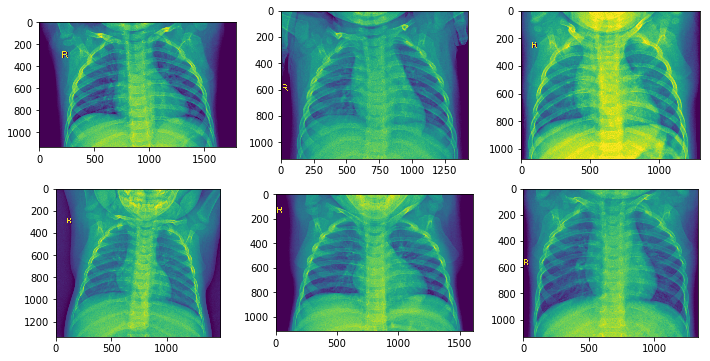

In [12]:
# Plot normal x ray
plot_images(train_dir + '/NORMAL')

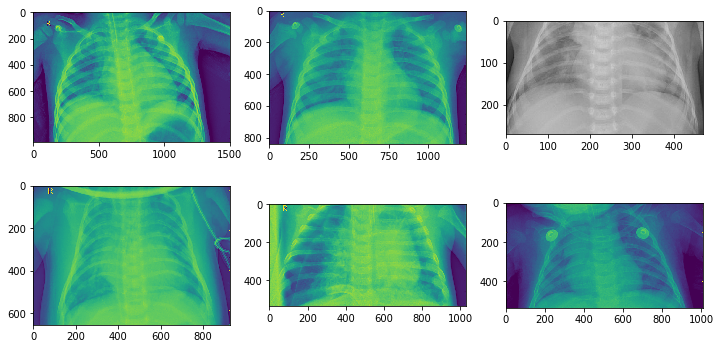

In [13]:
# Plot Bacterial pneumonia
plot_images(train_dir + '/PNEUMONIA_BACTERIA')


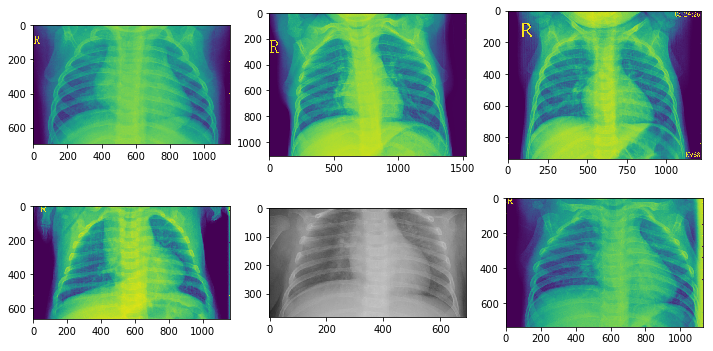

In [14]:
# Plot Virus pneumonia
plot_images(train_dir + '/PNEUMONIA_VIRUS')


### Train the model!

Remember to use the GPU instance!!!

The training will be much faster than the CPU

In [15]:
# Define the parameters for the model
rescale = 1./255.0
target_size = (150, 150)
batch_size = 64
class_mode = 'categorical'

# Train set
train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=rescale
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

# Test set
test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1
)

# Validation set
validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)



Found 5216 images belonging to 3 classes.
Found 624 images belonging to 3 classes.
Found 16 images belonging to 3 classes.


In [0]:
# Get the InceptionV3 model

def get_model():
  base_model = InceptionV3(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  x = keras.layers.BatchNormalization()(x)
  # Predictions are 3 neurons for the 3 categories
  predictions = keras.layers.Dense(3, activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = False
  
  model.summary()
  return model


In [17]:
# Get the model
model = get_model()










87916544/87910968 [==============================] - 28s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________

In [0]:
# Fit the model
model.compile(keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    verbose=1,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
82/82 [==============================] - 88s 1s/step - loss: 0.9447 - acc: 0.6340 - val_loss: 4.4769 - val_acc: 0.4359
Epoch 2/10
82/82 [==============================] - 73s 888ms/step - loss: 0.6915 - acc: 0.6982 - val_loss: 2.0704 - val_acc: 0.5000
Epoch 3/10
82/82 [==============================] - 75s 911ms/step - loss: 0.6745 - acc: 0.7067 - val_loss: 1.9782 - val_acc: 0.5465
Epoch 4/10
82/82 [==============================] - 74s 908ms/step - loss: 0.6759 - acc: 0.6957 - val_loss: 1.4986 - val_acc: 0.5913
Epoch 5/10
82/82 [==============================] - 76s 923ms/step - loss: 0.6818 - acc: 0.6944 - val_loss: 3.1666 - val_acc: 0.5048
Epoch 6/10
82/82 [==============================] - 75s 917ms/step - loss: 0.6572 - acc: 0.7125 - val_loss: 1.9552 - val_acc: 0.4663
Epoch 7/10
82/82 [==============================] - 76s 928ms/step - loss: 0.6566 - acc: 0.7109 - val_loss: 2.

In [0]:
result  = model.evaluate_generator(validation_generator, steps=len(validation_generator), verbose=1)
print('Loss:', result[0])
print('Accuracy:', result[1])


### Prediction

In [0]:
# Predict the validation set
y_pred_batches = []
y_true_batches = []

for i in range(0, len(validation_generator)):
  y_img_batch, y_true_batch = validation_generator[i]
  y_true_batch = y_true_batch.argmax(axis=-1)

  y_true_batches.append(y_true_batch)

  y_pred_batch = model.predict(y_img_batch)
  y_pred_batch = y_pred_batch.argmax(axis=-1)
  y_pred_batches.append(y_pred_batch)


print(y_pred_batches)


In [0]:
# Helper function to plot the prediction of the validation set
def predict_images(images_path, label):
  amount = 0
  fig = plt.figure(figsize=(18, 8))

  for file in os.listdir(images_path):
    if file.endswith('.jpeg'):
      if amount == 8:
        break
      # True vs Pred
      true_label = ''

      if y_pred_batch[amount] == 0:
        true_label = 'NORMAL'
      if y_pred_batch[amount] == 1:
        true_label = 'PNEUMONIA_BACTERIA'
      if y_pred_batch[amount] == 2:
        true_label = 'PNEUMONIA_VIRUS'

      img = mpimg.imread(os.path.join(images_path, file))
      plt.subplot(241+amount)
      plt.title('{} ---- {}'.format(label, true_label))
      imgplot = plt.imshow(img)

      amount += 1

In [0]:
# Predict for Normal from validation
predict_images('./chest_xray/val/NORMAL', 'NORMAL')


In [0]:
# Predict for Normal from test
predict_images('./chest_xray/test/NORMAL', 'NORMAL')

In [0]:
# Predict for PNEUMONIA_BACTERIA
predict_images('./chest_xray/val/PNEUMONIA_BACTERIA', 'PNEUMONIA_BACTERIA')


In [0]:
# Predict for PNEUMONIA_BACTERIA from test
predict_images('./chest_xray/test/PNEUMONIA_BACTERIA', 'PNEUMONIA_BACTERIA')

### Save the model

In [0]:
# save the model
model.save('xray_model.h5')


In [0]:
# load the model
new_model = keras.models.load_model('xray_model.h5')

### Tensorflow js

Convert the keras model to Tensorflow js for use in a webapp

In [0]:
# The new version of tensorflowjs has a bug, use this one
!pip install tensorflowjs==1.2.6


In [0]:
# Save as Tensorflowjs

!mkdir model
!tensorflowjs_converter --input_format keras xray_model.h5 model/

In [0]:
# Zip the file
!zip -r xray_model.zip model


In [5]:
# Download files
from google.colab import files

# model in keras format
files.download("xray_model.h5")


----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 60894, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [0]:
# Model in tensorflowjs format
files.download('xray_model.zip')